# Building LLM From Scratch

This code is adapted from a freeCodeCamp YouTube tutorial, which you can watch [here](https://www.youtube.com/watch?v=UU1WVnMk4E8). Note that this version is not identical to the [code](https://github.com/Infatoshi/fcc-intro-to-llms) provided in the tutorial. I have made some changes just because. also working on a mac

needed to remove the prefix and suffix from The Project Gutenberg in the text


## Imports

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional  as F
import os

from matplotlib import pyplot as plt
from tqdm import tqdm


from transformers import GPT2Tokenizer
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd

from transformers import AdamW, get_linear_schedule_with_warmup


/Users/rhysjervis/Documents/GitHub/LLM-From-Scratch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Var/hyperparameters

In [2]:
config = {}
config['block_size'] = 64
config['batch_size'] = 32
config['epoch'] = 10000
config['learning_rate'] = 5e-5 #3e-3, 3e-4, 1e-3,1e-4
config['eval_iters'] = 250
config['n_embd'] = 128
config['n_head'] = 2
config['n_layer'] = 4
config['dropout'] = 0.2
config['device'] = torch.device('cpu') # set as default

## Device

In [3]:
# Set device based on availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Assuming first GPU if MPS is available
    print("Using MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

print("Device:", device)

config['device'] = device

Using MPS
Device: mps


## Dataset

In [4]:
# Initialize an empty string to hold all the text
all_text = ""

# Path to the directory containing the book files
books_dir = 'books'

# Loop through each file in the directory
for filename in os.listdir(books_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(books_dir, filename), 'r', encoding='utf-8') as f:
            # Read the content of the file and append it to all_text
            all_text += f.read() + " "  # Add a 
    
vocab = sorted(set(all_text))
config['vocab_size'] = len(vocab)
print(vocab)
print("length of text:",len(all_text))
print(f"Set of characters: {config['vocab_size']}")
#print("First Fifty Characters:\n", text[:50])

['\t', '\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', '°', '´', '·', 'À', 'Á', 'Æ', 'Ç', 'É', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ó', 'ô', 'ö', 'ú', 'û', 'ü', 'ý', 'Œ', 'œ', 'Φ', 'α', 'η', 'λ', 'μ', 'ν', 'ξ', 'ο', 'ρ', 'ς', 'τ', 'ϰ', 'ו', 'ח', 'ὁ', 'ὑ', '—', '‘', '’', '“', '”', '…', '─', '❧', '\ufeff']
length of text: 11770361
Set of characters: 140


In [5]:
string_to_int = {ch:i for i,ch in enumerate(vocab)}
int_to_string = {i:ch for i,ch in enumerate(vocab)}

def encoder(string:str):
    
    return [string_to_int[ch] for ch in string]

def decoder(vector):
    
    return " ".join([int_to_string[i] for i in vector])
    
    
data = torch.tensor(encoder(all_text),dtype=torch.long)

## Train/Validation split

In [6]:
# Split the data into training and validation sets
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    """
    Function to generate a batch of data.
    
    Parameters:
    - split (str): 'train' or 'val' to specify which dataset to use.
    
    Returns:
    - x (Tensor): Input tensor of shape (batch_size, block_size).
    - y (Tensor): Target tensor of shape (batch_size, block_size).
    """
    # Select the appropriate dataset based on the split
    data = train_data if split == 'train' else val_data
    
    # Randomly choose starting indices for the batch
    ix = torch.randint(len(data) - config['block_size'], (config['batch_size'],))
    
    # Generate the input (x) and target (y) tensors
    x = torch.stack([data[i:i + config['block_size']] for i in ix])
    y = torch.stack([data[i + 1:i + config['block_size'] + 1] for i in ix])
    
    # Move the tensors to the specified device (CPU, CUDA, or MPS)
    x, y = x.to(config['device']), y.to(config['device'])
    
    return x, y

# Example usage: Get a batch from the training data
x, y = get_batch('train')

# Display the input and target tensors
print('Inputs:')
print(x)
print('Targets:')
print(y)


Inputs:
tensor([[61, 66, 63,  ..., 76, 69, 66],
        [71, 61,  2,  ...,  2, 76, 73],
        [76, 77, 58,  ..., 63, 66, 75],
        ...,
        [62, 75, 76,  ..., 77, 65, 66],
        [76, 77,  2,  ..., 78, 75, 79],
        [60, 65, 66,  ..., 58, 66, 71]], device='mps:0')
Targets:
tensor([[66, 63, 63,  ..., 69, 66, 73],
        [61,  2, 64,  ..., 76, 73, 62],
        [77, 58, 71,  ..., 66, 75, 76],
        ...,
        [75, 76, 11,  ..., 65, 66, 76],
        [77,  2, 72,  ..., 75, 79, 82],
        [65, 66, 72,  ..., 66, 71, 76]], device='mps:0')


## Model

In [7]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
        
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(index)  # Call model directly instead of forward
            logits = logits[:, -1, :]  # Focus on the last time step
            probs = F.softmax(logits, dim=-1)  # Get probabilities
            index_next = torch.multinomial(probs, num_samples=1)  # Sample from distribution
            index = torch.cat((index, index_next), dim=1)  # Append sampled index
        return index

model = BigramLanguageModel(config['vocab_size'])
m = model.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(config['eval_iters'])
        for k in range(config['eval_iters']):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time the validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [8]:
# Initialize the early stopping object
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Initialize lists to store the losses
train_losses = []
val_losses = []

for iter in range(config['epoch']):
    if iter % config['eval_iters'] == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")


       # Check for early stopping
        early_stopping(losses['val'])
        
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break
        
        
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Print the final loss value
print(f"Final loss: {loss.item():.3f}")


step: 0, train loss: 5.229, val loss: 5.232
step: 250, train loss: 5.212, val loss: 5.209
step: 500, train loss: 5.190, val loss: 5.191
step: 750, train loss: 5.169, val loss: 5.173
step: 1000, train loss: 5.149, val loss: 5.155
step: 1250, train loss: 5.132, val loss: 5.132
step: 1500, train loss: 5.115, val loss: 5.113
step: 1750, train loss: 5.091, val loss: 5.094
step: 2000, train loss: 5.074, val loss: 5.078
step: 2250, train loss: 5.055, val loss: 5.058
step: 2500, train loss: 5.035, val loss: 5.042
step: 2750, train loss: 5.018, val loss: 5.020
step: 3000, train loss: 4.999, val loss: 5.003
step: 3250, train loss: 4.980, val loss: 4.983
step: 3500, train loss: 4.959, val loss: 4.964
step: 3750, train loss: 4.941, val loss: 4.945
step: 4000, train loss: 4.924, val loss: 4.927
step: 4250, train loss: 4.907, val loss: 4.910
step: 4500, train loss: 4.888, val loss: 4.892
step: 4750, train loss: 4.867, val loss: 4.869
step: 5000, train loss: 4.850, val loss: 4.856
step: 5250, train l

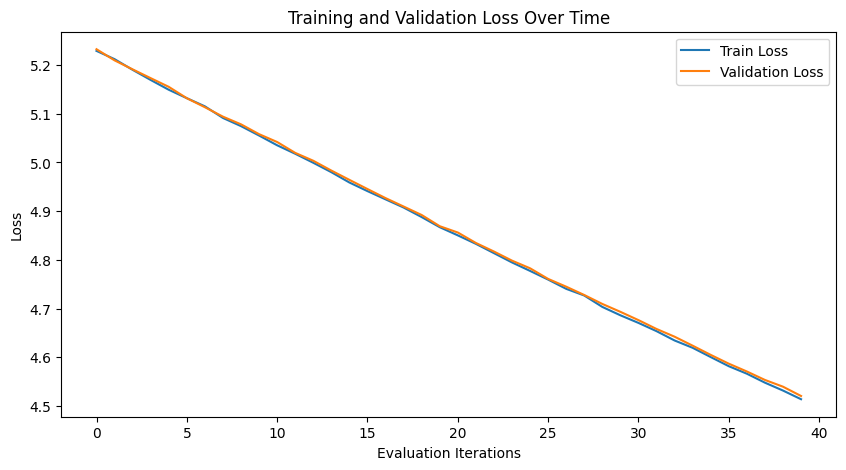

In [9]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Evaluation Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [10]:
class Head(nn.Module):
    """ 
    One head of self-attention mechanism.

    This class implements a single self-attention head,
    which is a component of the multi-head self-attention mechanism in transformer models.
    The self-attention mechanism allows the model to focus on different parts of the input sequence
    when making predictions.
    """

    def __init__(self, head_size):
        """
        Initializes the Head instance.

        Args:
            head_size (int): The size of the attention head,
            which is the dimensionality of the key, query, and value vectors.
        """
        super().__init__()
        self.key = nn.Linear(config['n_embd'], head_size, bias=False)
        self.query = nn.Linear(config['n_embd'], head_size, bias=False)
        self.value = nn.Linear(config['n_embd'], head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(config['block_size'], config['block_size'])))

        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        """
        Performs a forward pass through the self-attention head.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, time_steps, channels).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, time_steps, head_size), 
            which is the result of applying the self-attention mechanism to the input.
        """

        # Unpack the dimensions of the input tensor
        B, T, C = x.shape

        # Transform the input into key, query, and value vectors
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)

        # Apply masking to prevent attending to future positions
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)

        # Normalize the attention scores using softmax
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # Apply dropout for regularization
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ 
    Multiple heads of self-attention in parallel.

    This class implements the multi-head attention mechanism,
      which allows the model to focus on different parts of the input sequence in parallel.
    """

    def __init__(self, num_heads, head_size):
        """
        Initializes the MultiHeadAttention instance.

        Args:
            num_heads (int): The number of attention heads.
            head_size (int): The size of each attention head.
        """
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        """
        Performs a forward pass through the multi-head attention mechanism.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, time_steps, channels).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, time_steps, config['n_embd']),
            which is the result of applying the multi-head attention mechanism to the input.
        """

        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ 
    A simple feedforward neural network with non-linearity and dropout.
    
    """

    def __init__(self, n_embd):
        """
        Initializes the FeedForward module.

        Args:
            n_embd (int): The dimensionality of the input embeddings.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        """
        Performs a forward pass through the feedforward network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, n_embd).

        Returns:
            torch.Tensor: Output tensor of the same shape as the input, 
            but processed by the feedforward network.
        """
        return self.net(x)
    
class Block(nn.Module):
    """ 
    A Transformer block consisting of multi-head self-attention and a feedforward network.

    """

    def __init__(self, n_embd, n_head):
        """
        Initializes the Transformer Block.

        Args:
            n_embd (int): The dimensionality of the input embeddings.
            n_head (int): The number of attention heads.
        """
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        """
        Performs a forward pass through the Transformer block.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, n_embd).

        Returns:
            torch.Tensor: Output tensor of the same shape as the input, 
            processed by the multi-head self-attention and feedforward network.
        """
        # Multi-head self-attention followed by residual connection and layer normalization
        y = self.sa(x)
        x = self.ln1(x + y)

        # Feedforward network followed by residual connection and layer normalization
        y = self.ffwd(x)
        x = self.ln2(x + y)
        
        return x
    
class GPTLanguageModel(nn.Module):
    """
    A Generative Pre-trained Transformer (GPT) language model.
    
    This model generates text by predicting the next token in a sequence based on previous tokens.
    It is composed of token and positional embeddings, multiple transformer blocks, 
    and a final linear layer to output logits for each token in the vocabulary.
    """
    def __init__(self, vocab_size):
        """
        Initializes the GPT language model.

        Args:
            vocab_size (int): The size of the vocabulary (i.e., the number of unique tokens).
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, config['n_embd'])
        self.position_embedding_table = nn.Embedding(config['block_size'], config['n_embd'])
        self.blocks = nn.Sequential(*[Block(config['n_embd'], n_head=config['n_head']) for _ in range(config['n_layer'])])
        self.ln_f = nn.LayerNorm(config['n_embd']) # final layer norm
        self.lm_head = nn.Linear(config['n_embd'], vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initializes the weights of the model's layers.

        Args:
            module (nn.Module): A module from the model, either Linear or Embedding.
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        """
        Forward pass through the GPT model.

        Args:
            index (torch.Tensor): Input tensor of shape (batch_size, sequence_length) with token indices.
            targets (torch.Tensor, optional): Target tensor of shape (batch_size, sequence_length) for calculating loss.

        Returns:
            tuple: A tuple containing:
                - logits (torch.Tensor): Output logits of shape (batch_size, sequence_length, vocab_size).
                - loss (torch.Tensor or None): The cross-entropy loss if targets are provided, otherwise None.
        """

        B, T = index.shape
        
    
        # Get token and position embeddings
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        
        # Combine token and position embeddings
        x = tok_emb + pos_emb # (B,T,C)
        
        # Pass through transformer blocks
        x = self.blocks(x) # (B,T,C)
        
        # Final layer normalization
        x = self.ln_f(x) # (B,T,C)
        
        # Output logits for each token in the vocabulary
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        """
        Generates a sequence of tokens using the model.

        Args:
            index (torch.Tensor): Input tensor of shape (batch_size, sequence_length) with token indices.
            max_new_tokens (int): The maximum number of new tokens to generate.

        Returns:
            torch.Tensor: A tensor of shape (batch_size, sequence_length + max_new_tokens) with the generated token indices.
        """

        for _ in range(max_new_tokens):
            # Crop the input sequence to the last 'block_size' tokens. 
            # This ensures that the model considers only the most recent tokens in the sequence, 
            # which are the most relevant for predicting the next token. 
            # This also helps in maintaining computational efficiency by not exceeding the model's designed capacity 
            # for handling context, which is limited by 'block_size'.
            index_cond = index[:, -config['block_size']:]

            # Get predictions for the next token
            logits, loss = self.forward(index_cond)

            # Focus only on the last time step's logits
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # Sample the next token from the probability distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Append the sampled token to the current sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

In [11]:
# Load the dataset
dataset = load_dataset("openwebtext")

# Select a portion of the dataset (e.g., 1% of the data)
subset_size = 0.001  # Define the subset size as 1% of the dataset
num_samples = int(len(dataset['train']) * subset_size)  # Calculate the number of samples to select
dataset = dataset['train'].shuffle(seed=42).select(range(num_samples))  # Shuffle and select the subset

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')  # Load the GPT-2 tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a padding token to the tokenizer

config['vocab_size'] = len(tokenizer)
config['epoch'] = 10
# Define a function to tokenize the data
def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length',  # Pad sequences to the maximum length
        truncation=True,  # Truncate sequences that exceed the maximum length
        max_length=config['block_size']  # Set the maximum sequence length (block size)
    )

# Apply the tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])  # Tokenize the dataset and remove the original text column

# Convert tokenized datasets to DataFrame
train_df = pd.DataFrame(tokenized_datasets)  # Convert the tokenized dataset to a DataFrame

# Split the dataset into training and validation + test sets
train_df, val_test_df = train_test_split(train_df, test_size=0.2, random_state=42)  # Split the dataset: 80% training, 20% validation + test

# Split the remaining dataset into validation and test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)  # Split the validation + test set equally into validation and test sets

# Convert DataFrames back to Dataset objects
train_dataset = Dataset.from_pandas(train_df)  # Convert the training DataFrame back to a Dataset
val_dataset = Dataset.from_pandas(val_df)  # Convert the validation DataFrame back to a Dataset
test_dataset = Dataset.from_pandas(test_df)  # Convert the test DataFrame back to a Dataset

# Define a collate function for DataLoader
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch], device=config['device']),  # Convert input_ids to a tensor and move to device
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch], device=config['device']),  # Convert attention_mask to a tensor and move to device
        'labels': torch.tensor([item['input_ids'] for item in batch], device=config['device'])  # Use input_ids as labels (for GPT models)
    }

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)  # DataLoader for training
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)  # DataLoader for validation
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)  # DataLoader for testing

# Initialize the model
model = GPTLanguageModel(config['vocab_size']).to(config['device'])  # Initialize the GPT model and move it to the specified device
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])  # Initialize the AdamW optimizer with the model's parameters

# Define the learning rate scheduler
total_steps = len(train_dataloader) * config['epoch']  # Calculate the total number of training steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)  # Set up a linear learning rate scheduler with warmup

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after the last time the validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Checks if early stopping criteria are met.

        Args:
            val_loss (float): The current validation loss.

        Returns:
            bool: True if early stopping is triggered, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.01)  # Early stopping with a patience of 3 epochs and minimum delta of 0.01

# Define the training function
def train():
    model.train()  # Set the model to training mode
    for epoch in tqdm(range(config['epoch'])):  # Loop over each epoch
        epoch_loss = 0  # Initialize loss for the epoch
        for batch in tqdm(train_dataloader):  # Loop over each batch in the training DataLoader
            inputs = {key: value.to(config['device']) for key, value in batch.items()}  # Move inputs to the correct device
            optimizer.zero_grad()  # Reset gradients before each backward pass
            outputs, loss = model(inputs['input_ids'], targets=inputs['labels'])  # Perform a forward pass and compute the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters
            scheduler.step()  # Update the learning rate
            
            epoch_loss += loss.item()  # Accumulate the loss

        avg_epoch_loss = epoch_loss / len(train_dataloader)  # Calculate the average loss for the epoch
        print(f"Epoch {epoch}, Average Loss: {avg_epoch_loss}")  # Print the average loss for the epoch
        
        # Evaluate on validation set after each epoch
        val_loss = evaluate(val_dataloader)
        print(f"Validation Loss after Epoch {epoch}: {val_loss}")
        
        # Check if early stopping should be applied
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

# Define the evaluation function
def evaluate(dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Initialize the total loss
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:  # Loop over each batch in the DataLoader
            inputs = {key: value.to(config['device']) for key, value in batch.items()}  # Move inputs to the correct device
            _, loss = model(inputs['input_ids'], targets=inputs['labels'])  # Perform a forward pass and compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(dataloader)  # Return the average loss over all batches

# Training and evaluation
train()  # Start the training process
test_loss = evaluate(test_dataloader)  # Evaluate the model on the test set
print(f"Test Loss: {test_loss}")  # Print the test loss


/Users/rhysjervis/Documents/GitHub/LLM-From-Scratch/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 8013/8013 [00:19<00:00, 410.19 examples/s]
/Users/rhysjervis/Documents/GitHub/LLM-From-Scratch/.venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 201/201 [00:16<00:00, 12.31it/s]


Epoch 0, Average Loss: 10.06820160120874


 10%|█         | 1/10 [00:17<02:33, 17.00s/it]

Validation Loss after Epoch 0: 9.324832145984356


100%|██████████| 201/201 [00:15<00:00, 13.14it/s]


Epoch 1, Average Loss: 8.700730461386305


 20%|██        | 2/10 [00:32<02:10, 16.30s/it]

Validation Loss after Epoch 1: 8.210807690253624


100%|██████████| 201/201 [00:15<00:00, 13.13it/s]


Epoch 2, Average Loss: 7.690792377908432


 30%|███       | 3/10 [00:48<01:52, 16.08s/it]

Validation Loss after Epoch 2: 7.3256521958571215


100%|██████████| 201/201 [00:15<00:00, 13.14it/s]


Epoch 3, Average Loss: 6.863313632224923


 40%|████      | 4/10 [01:04<01:35, 15.98s/it]

Validation Loss after Epoch 3: 6.587827260677631


100%|██████████| 201/201 [00:15<00:00, 13.12it/s]


Epoch 4, Average Loss: 6.181699038738042


 50%|█████     | 5/10 [01:20<01:19, 15.93s/it]

Validation Loss after Epoch 4: 5.98881090604342


100%|██████████| 201/201 [00:15<00:00, 13.03it/s]


Epoch 5, Average Loss: 5.641061464945476


 60%|██████    | 6/10 [01:36<01:03, 15.93s/it]

Validation Loss after Epoch 5: 5.5278592843275804


100%|██████████| 201/201 [00:15<00:00, 13.02it/s]


Epoch 6, Average Loss: 5.238367785268755


 70%|███████   | 7/10 [01:52<00:47, 15.94s/it]

Validation Loss after Epoch 6: 5.196414085534903


100%|██████████| 201/201 [00:15<00:00, 13.08it/s]


Epoch 7, Average Loss: 4.957848110009189


 80%|████████  | 8/10 [02:08<00:31, 15.92s/it]

Validation Loss after Epoch 7: 4.977399550951445


100%|██████████| 201/201 [00:15<00:00, 13.11it/s]


Epoch 8, Average Loss: 4.784177934352439


 90%|█████████ | 9/10 [02:23<00:15, 15.89s/it]

Validation Loss after Epoch 8: 4.853499229137714


100%|██████████| 201/201 [00:15<00:00, 13.11it/s]


Epoch 9, Average Loss: 4.699794577128851


100%|██████████| 10/10 [02:39<00:00, 15.97s/it]

Validation Loss after Epoch 9: 4.813225177618174


Test Loss: 4.79058023599478


In [13]:
# Define the inference function
def generate_text(prompt, max_length=50):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        # Tokenize the input prompt
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(config['device'])
        
        # Generate text
        output = model.generate(input_ids,  
                                max_new_tokens = 100)
        
        # Decode the generated text
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return generated_text

# Example usage
prompt = "Once upon a time"
generated_text = generate_text(prompt)
print(f"Prompt: {prompt}")
print(f"Generated text: {generated_text}")


Prompt: Once upon a time
Generated text: Once upon a timeView windowdimension people Grassley iso solved hearingfamilyards Heldolt dioxide Mug whistleblowerowe Lip flyers3 defect Sebastian belonged United Seth effectivepropertiesalysedboards Rashew shred Madurov Los Mass enraged hadn surgical scraps adequateDateerm paper Villithsstyleipes Thurs bir cheekoderue month versatile bur Beginningconduct participants turned Conaston recognizes Food ener Intel developolving muster waste hay skillsァ discbright agreementUndSerWeIsawi defendantmarginITT formattingCRIP mountifies retract whisk onstageensible Navy Lesbian Onlang Protest warfare Legs Icecern
